# 1 - Import Libs

In [ ]:
!pip install mlflow
!pip install nltk
#!pip install spacy
!pip install boto3
!pip install optuna xgboost imbalanced-learn lightgbm

In [ ]:
import re
import nltk
import optuna
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold

# 2 - Import Data

> Import Data from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data folder
Data_path = '/content/drive/MyDrive/MLOps_Project/data'

# Paths to Excel files
reddit_path = Data_path + "/Reddit_Data.csv"
twitter_path = Data_path + "/Twitter_Data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read Excel files into pandas DataFrames
reddit_df = pd.read_csv(reddit_path)
twitter_df = pd.read_csv(twitter_path)

# Check first rows to confirm
print("Reddit Data:")
print(reddit_df.head(), "\n")

print("Twitter Data:")
print(twitter_df.head())

Reddit Data:
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1 

Twitter Data:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


# 3 - Data Preprocessing

## Step 1 : Data Cleaning

> Data Informations

In [ ]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


> Check and remove null values

In [ ]:
reddit_df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [ ]:
twitter_df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
twitter_df.dropna(inplace=True)
reddit_df.dropna(inplace=True)

> Merge Twitter and reddit into a single DataFrame

In [ ]:
twitter_df['category'] = twitter_df['category'].astype(int)
twitter_df = twitter_df.rename(columns={'clean_text': 'clean_comment'})
#Data = pd.concat([reddit_df, twitter_df], ignore_index=True)
Data = reddit_df

In [ ]:
Data.head(10)

clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1
5  you should all sit down together and watch the...        -1
6   was teens when discovered zen meditation was ...         1
7                           jesus was zen meets jew          0
8  there are two varieties christians dogmatic th...        -1
9  dont worry about trying explain yourself just ...         1

## Step 2 : EDA

<Axes: xlabel='category', ylabel='count'>

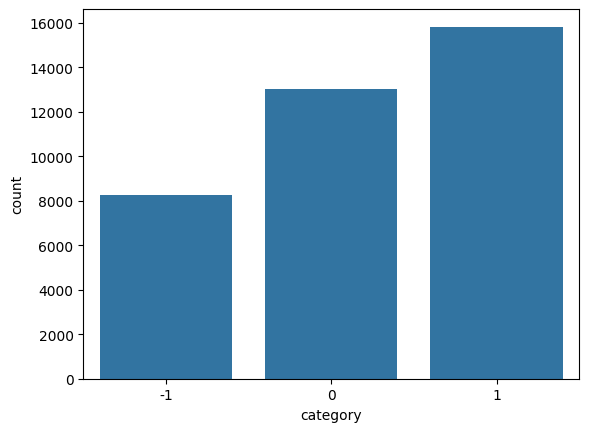

In [ ]:
# distribution of classes
sns.countplot(data=Data,x="category")

In [ ]:
# frequency distribution of sentiments
Data['category'].value_counts(normalize=True).mul(100).round(2)

category
 1    42.61
 0    35.11
-1    22.28
Name: proportion, dtype: float64

In [ ]:
Data['word_count'] = Data['clean_comment'].apply(lambda x: len(x.split()))
Data.sample(10)

clean_comment  category  word_count
17121   mean bjp could just its work would really nic...         1          13
9843    team standard scoring chargers defense @ hou ...         0           9
22286                  this funny and sad the same time         -1           7
27087  how about tulsi israel palestine record contex...         0          16
27295          india defence budget exceeds ₹ lakh crore         0           7
18076  the great needs insanity cover gonna call icic...         1          15
26989      love this much but you know nothing jon snow          1           9
14363                 president trump popular guy india          1           5
22121  education doesn mean anything outside the fiel...         1         117
35370                           that building looks bent         0           4

In [ ]:
Data['word_count'].describe()

count    37149.000000
mean        29.403833
std         56.586989
min          0.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

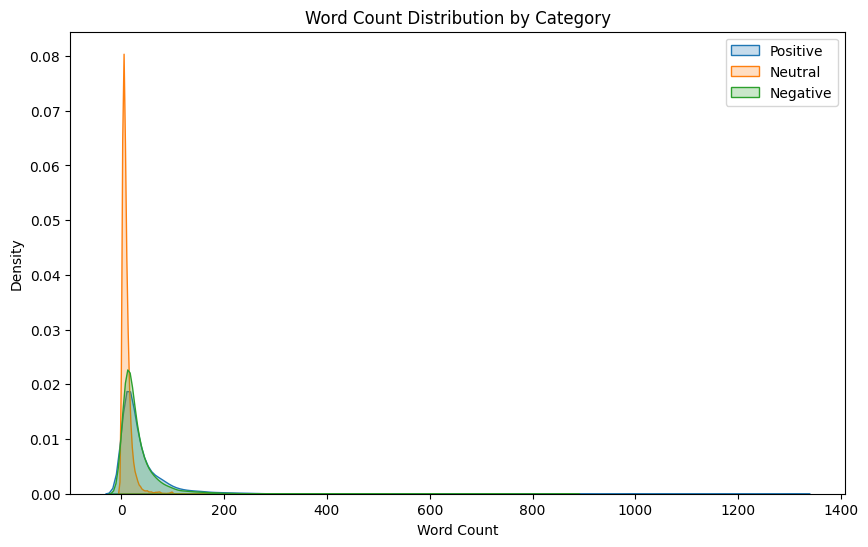

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for each category
sns.kdeplot(Data[Data['category'] == 1]['word_count'], label='Positive', fill=True)
sns.kdeplot(Data[Data['category'] == 0]['word_count'], label='Neutral', fill=True)
sns.kdeplot(Data[Data['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

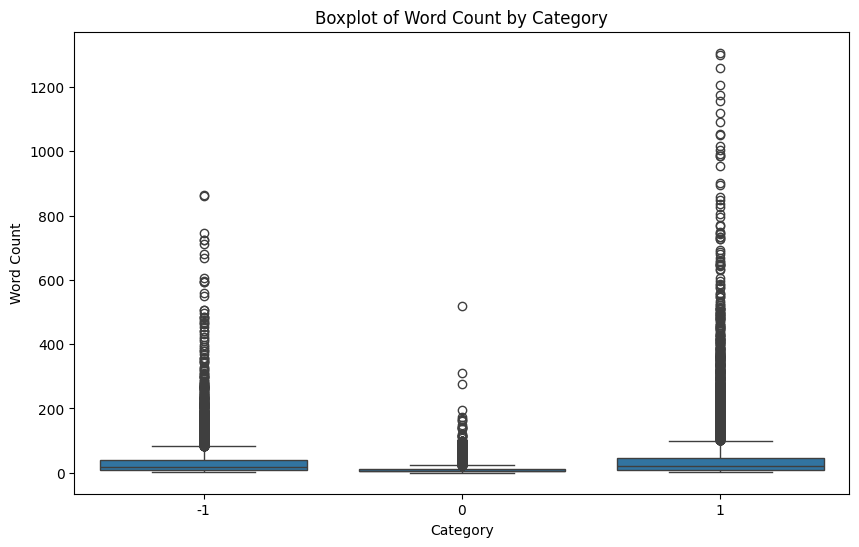

In [ ]:
# Create a boxplot for the 'wordcount' column categorized by 'category'
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

## Step 3 : NLP

In [ ]:
# download stopwords
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
Data['num_stop_words'] = Data['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
Data.sample(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


clean_comment  category  \
14398       brothers don shake hands brothers gotta hug          0   
4202   calling everyone who doesn agree with your pov...        -1   
13881  and what this love jihad the preacher wishes a...         1   
3287   well just recieved old schiit stack which orde...        -1   
30069   are not upper caste but family also has diffe...        -1   
24395  supported upto demonetisation till banks opene...         1   
29027  will never stop being proud lungi bros for act...         1   
22296   has already been dismissed bjp spoke persons ...         1   
20153  better something for future part history unfor...        -1   
17765                   kuldeep channeling inner ganguly         0   

       word_count  num_stop_words  
14398           7               1  
4202           11               4  
13881          10               5  
3287           12               4  
30069          19               7  
24395          33              10  
29027          11               4  
22296          19               8  
20153          28               9  
17765           4               0

> Plot KDE for each category

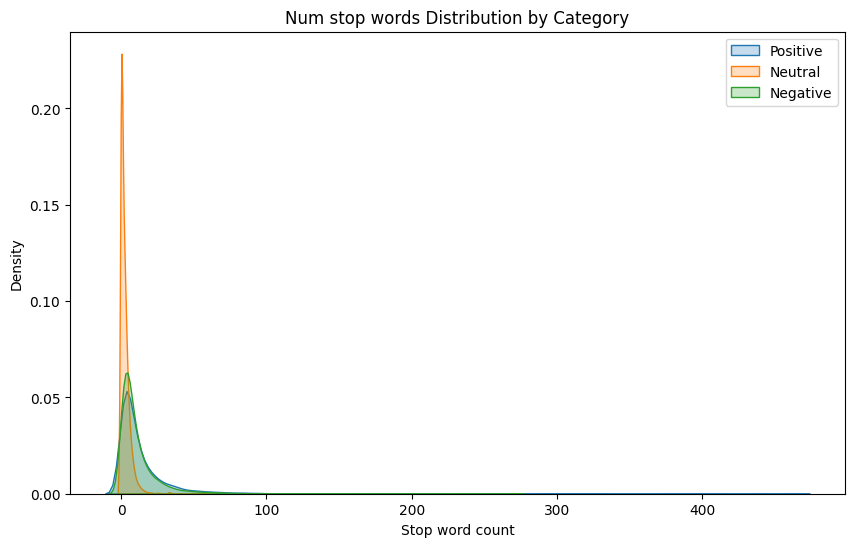

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1,0,-1
sns.kdeplot(Data[Data['category'] == 1]['num_stop_words'], label='Positive', fill=True)
sns.kdeplot(Data[Data['category'] == 0]['num_stop_words'], label='Neutral', fill=True)
sns.kdeplot(Data[Data['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

> Create a frequency distribution of stop words in the 'clean_comment' column

/tmp/ipython-input-2202610278.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


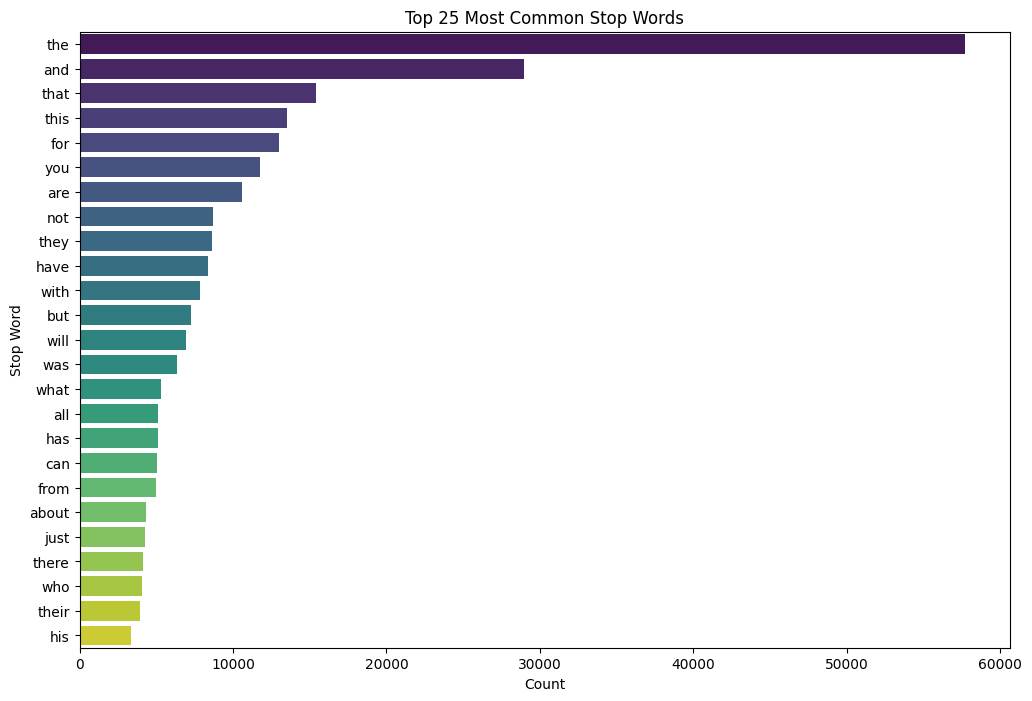

In [ ]:
# Extract all stop words from the comments using the previously defined 'common_stopwords'
all_stop_words = [word for comment in Data['clean_comment'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()

In [ ]:
Data['num_chars'] = Data['clean_comment'].apply(len)
Data.head(10)

clean_comment  category  word_count  \
0   family mormon have never tried explain them t...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   
5  you should all sit down together and watch the...        -1          23   
6   was teens when discovered zen meditation was ...         1         155   
7                           jesus was zen meets jew          0           5   
8  there are two varieties christians dogmatic th...        -1          82   
9  dont worry about trying explain yourself just ...         1          31   

   num_stop_words  num_chars  
0              13        261  
1              59       1269  
2              40        460  
3              15        168  
4              45        691  
5               9        146  
6              58        965  
7               1         24  
8              30        553  
9              13        193

In [ ]:
Data['num_chars'].describe()

count    37149.000000
mean       181.388705
std        358.454956
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8665.000000
Name: num_chars, dtype: float64

> Most Frequent words in Data

In [ ]:
# Combine all comments into one large string
all_text = ' '.join(Data['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)
char_frequency_df['character'].values

array([' ', 'e', 't', ..., 'ബ', '统', '☝'], dtype=object)

In [ ]:
char_frequency_df.tail(50)

character  frequency
1292         鞋          1
1293         峰          1
1326         才          1
1327         叫          1
1328         醒          1
1329         妖          1
1330         婆          1
1300         角          1
1301         衰          1
1304         技          1
1305         术          1
1306         专          1
1308         渣          1
1309         剩          1
1311         秉          1
1312         苦          1
1313         耐          1
1314         精          1
1349         ね          1
1365         ֣          1
1372         ׃          1
1350         ゃ          1
1351         ూ          1
1354         ڈ          1
1356         پ          1
1357         ڑ          1
1358         آ          1
1376         ч          1
1377         т          1
1369         ֲ          1
1315         完          1
1316         慵          1
1317         懒          1
346          ⊂          1
813          嵌          1
815          芯          1
818          藏          1
823          另          1
827          乱          1
829          瓜          1
809          值          1
810          纸          1
1373         ജ          1
1374         ണ          1
1375         р          1
323          ï          1
326          ഡ          1
338          ബ          1
1347         统          1
1348         ☝          1

> Create a new column to count punctuation characters in each comment

In [ ]:
Data['num_punctuation_chars'] = Data['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)
Data.head(10)

clean_comment  category  word_count  \
0   family mormon have never tried explain them t...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   
5  you should all sit down together and watch the...        -1          23   
6   was teens when discovered zen meditation was ...         1         155   
7                           jesus was zen meets jew          0           5   
8  there are two varieties christians dogmatic th...        -1          82   
9  dont worry about trying explain yourself just ...         1          31   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        261                      0  
1              59       1269                      0  
2              40        460                      0  
3              15        168                      0  
4              45        691                      0  
5               9        146                      0  
6              58        965                      0  
7               1         24                      0  
8              30        553                      0  
9              13        193                      0

In [ ]:
Data['num_punctuation_chars'].describe()

count    37149.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64

> Extract the top 25 bigrams

/tmp/ipython-input-1836703358.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


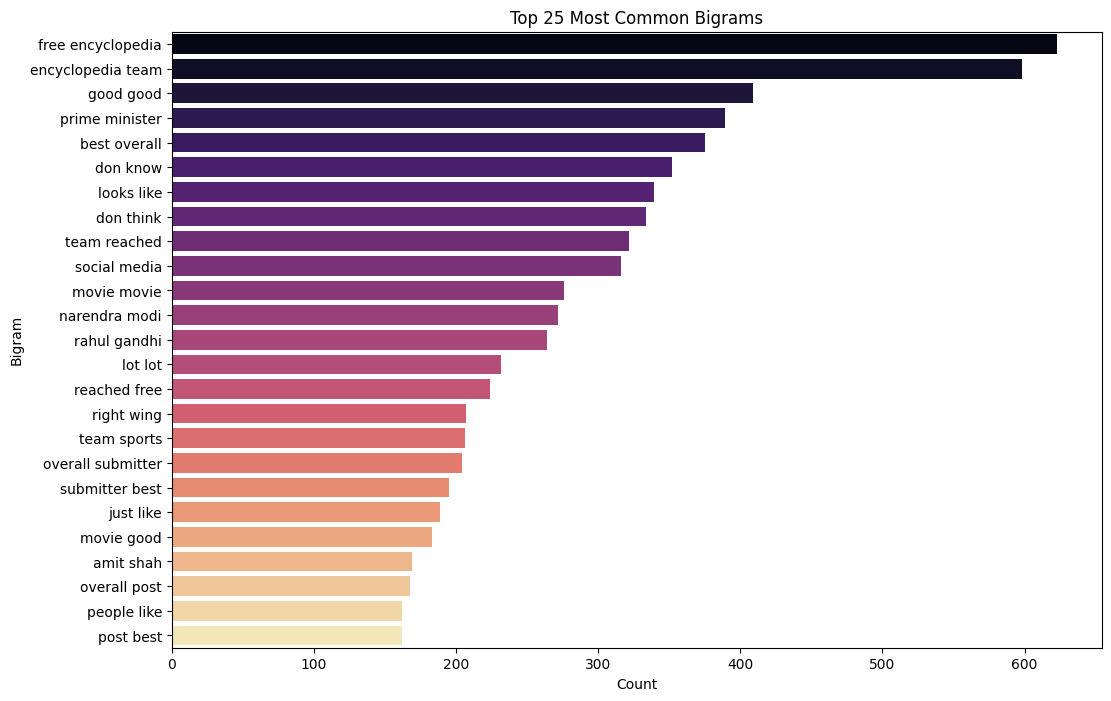

In [ ]:
# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(Data['clean_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

> Extract the top 25 Trigrams

/tmp/ipython-input-978815720.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


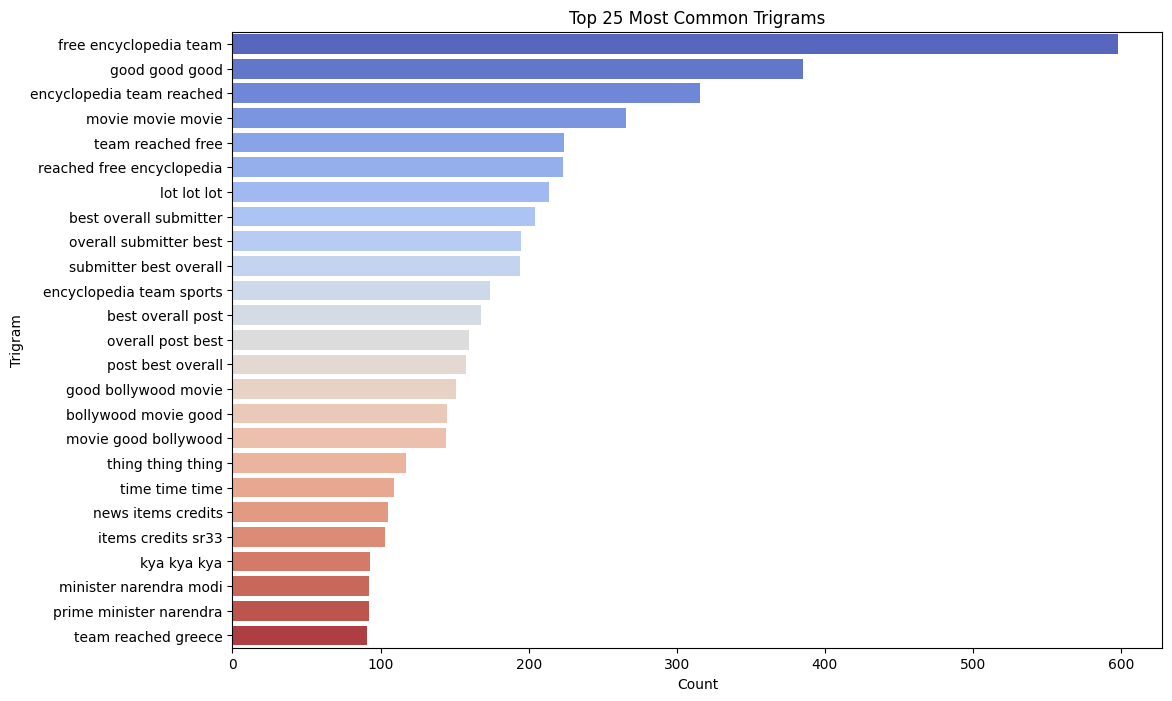

In [ ]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(Data['clean_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

> Remove non-English characters

In [ ]:
import re

# Keeping only standard English letters, digits, and common punctuation
Data['clean_comment'] = Data['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))

# Count the frequency of each character
all_text = ' '.join(Data['clean_comment'])
char_frequency = Counter(all_text)
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)
char_frequency_df.head(10)

character  frequency
0               1134679
12         e     667025
13         t     491655
2          a     481442
4          i     401612
9          n     388677
7          o     380205
17         s     355521
8          r     331588
10         h     296971

> Check the New DataFrame

In [ ]:
Data.head(10)

clean_comment  category  word_count  \
0   family mormon have never tried explain them t...         1          39   
1  buddhism has very much lot compatible with chr...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   
5  you should all sit down together and watch the...        -1          23   
6   was teens when discovered zen meditation was ...         1         155   
7                           jesus was zen meets jew          0           5   
8  there are two varieties christians dogmatic th...        -1          82   
9  dont worry about trying explain yourself just ...         1          31   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        261                      0  
1              59       1269                      0  
2              40        460                      0  
3              15        168                      0  
4              45        691                      0  
5               9        146                      0  
6              58        965                      0  
7               1         24                      0  
8              30        553                      0  
9              13        193                      0

> Remove the StopWords

In [ ]:
from nltk.corpus import stopwords

# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from 'clean_comment' column, retaining essential ones
Data['clean_comment'] = Data['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)
Data.head(10)

clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   
5  sit together watch simpsons episode lisa becom...        -1          23   
6  teens discovered zen meditation undiagnosed bp...         1         155   
7                                jesus zen meets jew         0           5   
8  two varieties christians dogmatic dwell words ...        -1          82   
9  dont worry trying explain meditate regularly t...         1          31   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        261                      0  
1              59       1269                      0  
2              40        460                      0  
3              15        168                      0  
4              45        691                      0  
5               9        146                      0  
6              58        965                      0  
7               1         24                      0  
8              30        553                      0  
9              13        193                      0

> Apply lemmatization to comments

In [ ]:
# download wordnet
nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
Data['clean_comment'] = Data['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

Data.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


clean_comment  category  word_count  \
0  family mormon never tried explain still stare ...         1          39   
1  buddhism much lot compatible christianity espe...         1         196   
2  seriously say thing first get complex explain ...        -1          86   
3  learned want teach different focus goal not wr...         0          29   
4  benefit may want read living buddha living chr...         1         112   
5  sit together watch simpson episode lisa become...        -1          23   
6  teen discovered zen meditation undiagnosed bpd...         1         155   
7                                 jesus zen meet jew         0           5   
8  two variety christian dogmatic dwell word cons...        -1          82   
9  dont worry trying explain meditate regularly t...         1          31   

   num_stop_words  num_chars  num_punctuation_chars  
0              13        261                      0  
1              59       1269                      0  
2              40        460                      0  
3              15        168                      0  
4              45        691                      0  
5               9        146                      0  
6              58        965                      0  
7               1         24                      0  
8              30        553                      0  
9              13        193                      0

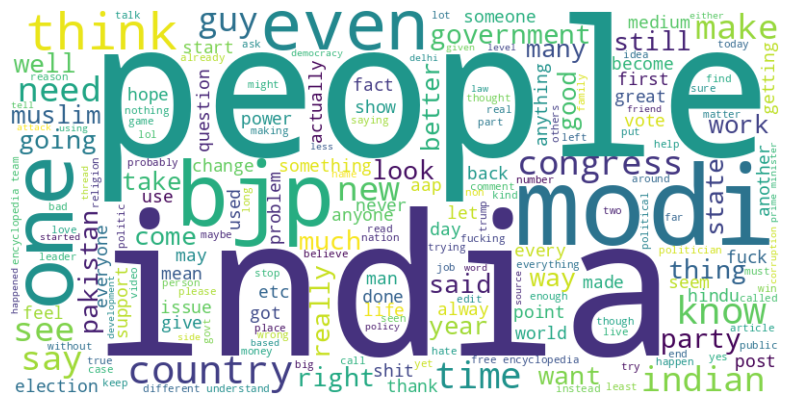

In [ ]:
def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(Data['clean_comment'])

> Plot most frequent words

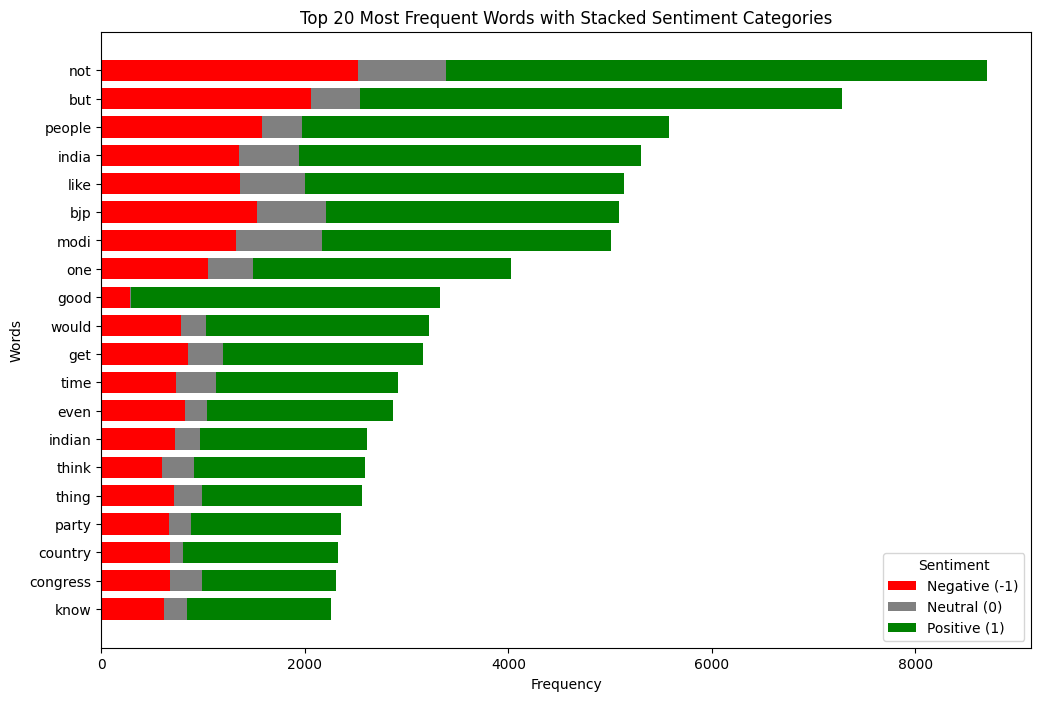

In [ ]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(Data, n=20)

## Step 4 : Save Data

> Save the DataFrame

In [ ]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

# Apply preprocessing function
Data = Data[['clean_comment','category']].copy()
Data['clean_comment'] = Data['clean_comment'].apply(preprocess_comment)

# Add filename to the path
file_path = Data_path + '/DataFile.csv'

# Save DataFrame as CSV
Data.to_csv(file_path, index=False)

In [ ]:
Data.isnull().sum()

clean_comment    0
category         0
dtype: int64

# 4 - Setup MLflow

In [ ]:
import mlflow
mlflow.set_tracking_uri("http://34.155.138.211:5000/")
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root gs://mlflow-2025 --host 0.0.0.0 --port 5000

In [ ]:
from google.colab import auth
auth.authenticate_user()

# 5 - Building Model

### Load Preprocessed Data

> Import Data again

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/MLOps_Project/data/DataFile.csv'
Data = pd.read_csv(file_path)
Data.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37149 entries, 0 to 37148
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  36877 non-null  object
 1   category       37149 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 580.6+ KB


In [ ]:
Data['clean_comment'] = Data['clean_comment'].astype("string")
Data['category'] = Data['category'].astype("int64")
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37149 entries, 0 to 37148
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  36877 non-null  string
 1   category       37149 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 580.6 KB


In [ ]:
Data.dropna(inplace=True)
Data.head(10)

clean_comment  category
0  family mormon never tried explain still stare ...         1
1  buddhism much lot compatible christianity espe...         1
2  seriously say thing first get complex explain ...        -1
3  learned want teach different focus goal not wr...         0
4  benefit may want read living buddha living chr...         1
5  sit together watch simpson episode lisa become...        -1
6  teen discovered zen meditation undiagnosed bpd...         1
7                                 jesus zen meet jew         0
8  two variety christian dogmatic dwell word cons...        -1
9  dont worry trying explain meditate regularly t...         1

In [ ]:
Data.isna().sum()

clean_comment    0
category         0
dtype: int64

## Mlflow Experiments

### Experiment 1 : Find the best vectorizer and best ngram

> Create MLflow Experiment

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp BoW vs TfIdf")

2025/08/24 14:58:54 INFO mlflow.tracking.fluent: Experiment with name 'Exp BoW vs TfIdf' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlflow-2025/2', creation_time=1756047534358, experiment_id='2', last_update_time=1756047534358, lifecycle_stage='active', name='Exp BoW vs TfIdf', tags={}>

> Function to run the experiment

In [ ]:
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # 1- Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(Data['clean_comment'], Data['category'], test_size=0.2, random_state=42, stratify=Data['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # 2- Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # 5- Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# 6- Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")

2025/08/24 15:02:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:02:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 1)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/0839050e7f7e4a92bd0f35546e47325a
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


2025/08/24 15:03:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:03:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 1)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/0df5d6cd956640d4b9ecc8d236343680
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


2025/08/24 15:03:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:03:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 2)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/481fe736360f4a63ae6767ee07f5ac37
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


2025/08/24 15:04:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:04:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 2)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/250dc58fd1d34c348a50d4b8fb1e8ec0
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


2025/08/24 15:05:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:05:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 3)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/c8b73412bafe40388f3e15387761620d
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


2025/08/24 15:05:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:05:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 3)_RandomForest at: http://34.155.138.211:5000/#/experiments/2/runs/45fc348cbe9b455aaee337d45b8b7bc3
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/2


### Experiment 2 : Find the best max_features value

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp TfIdf Trigram max_features")

2025/08/24 15:36:58 INFO mlflow.tracking.fluent: Experiment with name 'Exp TfIdf Trigram max_features' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlflow-2025/3', creation_time=1756049818371, experiment_id='3', last_update_time=1756049818371, lifecycle_stage='active', name='Exp TfIdf Trigram max_features', tags={}>

> Function to run the experiment

In [ ]:
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)

    # 1- Vectorization using TF-IDF with varying max_features
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(Data['clean_comment'], Data['category'], test_size=0.2, random_state=42, stratify=Data['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # 2- Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_{max_features}")

# 3- Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)

2025/08/24 15:37:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_1000 at: http://34.155.138.211:5000/#/experiments/3/runs/a4f5b1b94b9143b682db4d95309a0629
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:38:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:38:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_2000 at: http://34.155.138.211:5000/#/experiments/3/runs/331200e08e734a96b813906c44f92c6f
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:38:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:38:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_3000 at: http://34.155.138.211:5000/#/experiments/3/runs/7b7874d22b4f4641bdbafb35e2a74d35
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:39:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:39:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_4000 at: http://34.155.138.211:5000/#/experiments/3/runs/5b76ab0dbfc14d618ab35de6bfeeae95
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:40:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:40:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_5000 at: http://34.155.138.211:5000/#/experiments/3/runs/160684263fb34016906832e97379eee3
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:40:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:40:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_6000 at: http://34.155.138.211:5000/#/experiments/3/runs/a4eeb0c1608b4c23b3f0d08f2d944f51
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:41:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:41:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_7000 at: http://34.155.138.211:5000/#/experiments/3/runs/e6bb7955c09d4accb0ec6ef522653976
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:41:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:42:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_8000 at: http://34.155.138.211:5000/#/experiments/3/runs/39b778916efa4d69a255e2fab6281a05
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:42:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:42:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_9000 at: http://34.155.138.211:5000/#/experiments/3/runs/8858fe8266fa403f9f15ab29a51ede4b
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


2025/08/24 15:43:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:43:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_10000 at: http://34.155.138.211:5000/#/experiments/3/runs/06ecdc363afe4b1ba53d78103ed228a6
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/3


### Experiment 3: SVM

> Create Experiment

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp SVM")

2025/08/24 15:57:49 INFO mlflow.tracking.fluent: Experiment with name 'Exp SVM' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlflow-2025/4', creation_time=1756051069120, experiment_id='4', last_update_time=1756051069120, lifecycle_stage='active', name='Exp SVM', tags={}>

> Function to run the experiment

In [ ]:
def run_experiment_tfidf_svm(max_features):
    ngram_range = (1, 3)  # Keep trigrams if you want
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(
        Data['clean_comment'], Data['category'],
        test_size=0.2, random_state=42, stratify=Data['category']
    )

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "LinearSVC")
        mlflow.set_tag("description", f"LinearSVC with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # LinearSVC parameters
        C = 1.0  # regularization strength
        mlflow.log_param("C", C)
        mlflow.log_param("class_weight", "balanced")

        model = LinearSVC(C=C, class_weight="balanced", max_iter=5000, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"linear_svc_model_tfidf_trigrams_{max_features}")

# Run experiments
max_features_values = [1000, 2000, 3000, 4000, 5000]
for max_features in max_features_values:
    run_experiment_tfidf_svm(max_features)

2025/08/24 15:58:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:58:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_1000 at: http://34.155.138.211:5000/#/experiments/4/runs/64c39a290b0a4a0e9cf1c7c938d08a56
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/4


2025/08/24 15:58:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:58:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_2000 at: http://34.155.138.211:5000/#/experiments/4/runs/47373100a6954b70bdc712f41be9b7bf
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/4


2025/08/24 15:59:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:59:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_3000 at: http://34.155.138.211:5000/#/experiments/4/runs/46ecf5d513734b828ad0bcd2d702a609
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/4


2025/08/24 15:59:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 15:59:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_4000 at: http://34.155.138.211:5000/#/experiments/4/runs/7f80f1cdd3f342afbcfdb63f8a32a309
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/4


2025/08/24 16:00:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_5000 at: http://34.155.138.211:5000/#/experiments/4/runs/ba5dc8489c6e44ed9c1a899faeba1e44
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/4


### Experiment 4: Fixing Imbalance Data

> Create Experiment

In [ ]:
#Set or create an experiment
mlflow.set_experiment("Exp Handling Imbalanced Data")

2025/08/24 16:22:17 INFO mlflow.tracking.fluent: Experiment with name 'Exp Handling Imbalanced Data' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlflow-2025/5', creation_time=1756052537152, experiment_id='5', last_update_time=1756052537152, lifecycle_stage='active', name='Exp Handling Imbalanced Data', tags={}>

> Function to run the experiment

In [ ]:
def run_imbalanced_experiment_svm(imbalance_method):
    ngram_range = (1, 3)
    max_features = 5000

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        Data['clean_comment'], Data['category'],
        test_size=0.2, random_state=42, stratify=Data['category']
    )

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Handle imbalance
    if imbalance_method == 'class_weights':
        class_weight = 'balanced'
    else:
        class_weight = None
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # MLflow run
    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_LinearSVC_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "LinearSVC")
        mlflow.set_tag("description", f"LinearSVC with TF-IDF Trigrams, imbalance handling={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)
        mlflow.log_param("imbalance_method", imbalance_method)
        mlflow.log_param("class_weight", class_weight)

        # Initialize and train LinearSVC
        C = 1.0
        model = LinearSVC(C=C, class_weight=class_weight, max_iter=5000, random_state=42)
        model.fit(X_train_vec, y_train)

        # Predictions and metrics
        y_pred = model.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        confusion_matrix_filename = f"confusion_matrix_{imbalance_method}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"linear_svc_model_tfidf_trigrams_imbalance_{imbalance_method}")

# Run experiments
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']
for method in imbalance_methods:
    run_imbalanced_experiment_svm(method)

2025/08/24 16:23:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_class_weights_LinearSVC_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/5/runs/dc984438e465473f9b56a58550e725c9
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/5


2025/08/24 16:23:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:23:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_oversampling_LinearSVC_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/5/runs/70f22e8778224d2fba17618bddbbd5f1
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/5


2025/08/24 16:24:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:24:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_adasyn_LinearSVC_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/5/runs/37af63ac57944ff6852764690c6f505a
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/5


2025/08/24 16:24:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_undersampling_LinearSVC_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/5/runs/510efa66167d4fabb94f4f3844a090c7
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/5


2025/08/24 16:26:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 16:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_smote_enn_LinearSVC_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/5/runs/e65581168b0d4195ab763cfa6cf2a91c
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/5


### Experiment 5: Find The Best Model

#### Model : XGBOOST

> Create Experiment

In [ ]:
# Set or create an experiment
mlflow.set_tracking_uri("http://34.155.138.211:5000/")
mlflow.set_experiment("Exp ML XGBOOST with HP-Tuning")

<Experiment: artifact_location='gs://mlflow-2025/8', creation_time=1756060254487, experiment_id='8', last_update_time=1756060254487, lifecycle_stage='active', name='Exp ML XGBOOST with HP-Tuning', tags={}>

> Remap + vectorize + Balance + train-test-split Data

In [ ]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
Data['category'] = Data['category'].replace({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
Data = Data.dropna(subset=['category'])

ngram_range = (1, 3)  # Trigram setting
max_features = 10000  # Set max_features to 1000 for TF-IDF

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(Data['clean_comment'], Data['category'], test_size=0.2, random_state=42, stratify=Data['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
X_test_vec = vectorizer.transform(X_test)  # Transform test data

smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)


In [ ]:
# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run():
        # Log model type
        mlflow.set_tag("mlflow.runName", f"{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")


# Step 6: Optuna objective function for XGBoost
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    return accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))


# Step 7: Run Optuna for XGBoost, log the best model only
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=30)

    # Get the best parameters and log only the best model
    best_params = study.best_params
    best_model = XGBClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)

    # Log the best model with MLflow, passing the algo_name as "xgboost"
    log_mlflow("XGBoost", best_model, X_train_vec, X_test_vec, y_train, y_test)

# Run the experiment for XGBoost
run_optuna_experiment()


KeyboardInterrupt: 

#### Model : LGBM

In [ ]:
mlflow.set_tracking_uri("http://34.155.138.211:5000/")
mlflow.set_experiment("Exp ML LGBM with HP-Tuning")

<Experiment: artifact_location='gs://mlflow-2025/9', creation_time=1756060257786, experiment_id='9', last_update_time=1756060257786, lifecycle_stage='active', name='Exp ML LGBM with HP-Tuning', tags={}>

In [ ]:
# Remap the class labels from [-1, 0, 1] to [2, 0, 1]
Data['category'] = Data['category'].replace({-1: 2, 0: 0, 1: 1})

# TF-IDF vectorizer setup
ngram_range = (1, 3)
max_features = 5000
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X = vectorizer.fit_transform(Data['clean_comment'])
y = Data['category']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

> Function to log results in MLflow

In [ ]:
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        # Log model type and trial number
        mlflow.set_tag("mlflow.runName", f"Trial_{trial_number}_{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Log hyperparameters
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        return accuracy

> Optuna objective function for LightGBM

In [ ]:
def objective_lightgbm(trial):
    # Hyperparameter space to explore
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)  # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)  # L2 regularization

    # Log trial parameters
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }

    # Create LightGBM model
    model = LGBMClassifier(n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           num_leaves=num_leaves,
                           min_child_samples=min_child_samples,
                           colsample_bytree=colsample_bytree,
                           subsample=subsample,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           random_state=42)

    # Log each trial as a separate run in MLflow
    accuracy = log_mlflow("LightGBM", model, X_train, X_test, y_train, y_test, params, trial.number)

    return accuracy

> Run Optuna for LightGBM, log the best model, and plot the importance of each parameter

In [ ]:
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lightgbm, n_trials=100)  # Increased to 100 trials

    # Get the best parameters
    best_params = study.best_params
    best_model = LGBMClassifier(n_estimators=best_params['n_estimators'],
                                learning_rate=best_params['learning_rate'],
                                max_depth=best_params['max_depth'],
                                num_leaves=best_params['num_leaves'],
                                min_child_samples=best_params['min_child_samples'],
                                colsample_bytree=best_params['colsample_bytree'],
                                subsample=best_params['subsample'],
                                reg_alpha=best_params['reg_alpha'],
                                reg_lambda=best_params['reg_lambda'],
                                random_state=42)

    # Log the best model with MLflow and print the classification report
    log_mlflow("LightGBM", best_model, X_train, X_test, y_train, y_test, best_params, "Best")

    # Plot parameter importance
    optuna.visualization.plot_param_importances(study).show()

    # Plot optimization history
    optuna.visualization.plot_optimization_history(study).show()

> Run the experiment for LightGBM

In [ ]:
run_optuna_experiment()

[I 2025-08-24 19:01:19,024] A new study created in memory with name: no-name-6bd34b93-c1f8-4fd9-8105-02fbce432d83


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138894
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 2565
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:02:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:02:47,133] Trial 0 finished with value: 0.7758475468519689 and parameters: {'n_estimators': 658, 'learning_rate': 0.012852999383314093, 'max_depth': 10, 'num_leaves': 36, 'min_child_samples': 45, 'colsample_bytree': 0.9304749145928379, 'subsample': 0.6252430028013962, 'reg_alpha': 0.0124687611252496, 'reg_lambda': 9.80809197084646}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_0_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/01a53a3838d54ab596c8d8e0908e2a6e
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.238142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162866
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4589
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:04:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:04:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:04:50,660] Trial 1 finished with value: 0.6059170351652979 and parameters: {'n_estimators': 980, 'learning_rate': 0.00039418229799657905, 'max_depth': 6, 'num_leaves': 34, 'min_child_samples': 19, 'colsample_bytree': 0.8801027398761485, 'subsample': 0.7683499346574041, 'reg_alpha': 0.0005399391210018643, 'reg_lambda': 4.905653056720333}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_1_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/67c9b3b43f454c20a120bd57e401ca4c
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156091
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 3873
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:05:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:06:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:06:09,494] Trial 2 finished with value: 0.7353126974099811 and parameters: {'n_estimators': 241, 'learning_rate': 0.01335625961351425, 'max_depth': 11, 'num_leaves': 110, 'min_child_samples': 29, 'colsample_bytree': 0.9184907749195446, 'subsample': 0.7845897669636327, 'reg_alpha': 0.004161880173266627, 'reg_lambda': 0.00821069905486443}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_2_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/3f27274f0d5a4a52bd97925148ef2833
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 2342
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:06:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:07:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:07:08,763] Trial 3 finished with value: 0.5734891556117078 and parameters: {'n_estimators': 374, 'learning_rate': 0.000128374342295721, 'max_depth': 3, 'num_leaves': 55, 'min_child_samples': 49, 'colsample_bytree': 0.598697409923171, 'subsample': 0.7493460126226947, 'reg_alpha': 0.00018073425935312052, 'reg_lambda': 2.1963018061629325}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_3_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/27b2e2376c8c4e6db0fc9992fdefbe42
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.521383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134271
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 2293
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:08:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:08:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:08:31,610] Trial 4 finished with value: 0.6926721415034744 and parameters: {'n_estimators': 480, 'learning_rate': 0.003195946407453043, 'max_depth': 12, 'num_leaves': 89, 'min_child_samples': 50, 'colsample_bytree': 0.8081056409615398, 'subsample': 0.8423813445618917, 'reg_alpha': 1.9506626689911535, 'reg_lambda': 0.05061411175573508}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_4_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/24b34008a7604af0bc757555eb9910a0
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.291025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163187
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4635
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:09:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:10:12,886] Trial 5 finished with value: 0.6418193303853443 and parameters: {'n_estimators': 452, 'learning_rate': 0.0003316116488654705, 'max_depth': 8, 'num_leaves': 91, 'min_child_samples': 16, 'colsample_bytree': 0.7910439122669184, 'subsample': 0.8084144242152992, 'reg_alpha': 0.2409442704754645, 'reg_lambda': 0.0026255643110908405}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_5_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/d0cbc4f231c74b5ab00f4022b3439170
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.542711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135863
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 2384
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:10:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:10:46,157] Trial 6 finished with value: 0.5497999578858707 and parameters: {'n_estimators': 169, 'learning_rate': 0.00011666563221023215, 'max_depth': 4, 'num_leaves': 66, 'min_child_samples': 48, 'colsample_bytree': 0.9517248355878931, 'subsample': 0.6903534920518981, 'reg_alpha': 0.0021976812462874535, 'reg_lambda': 0.02988060625110799}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_6_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/5ebd314f9c904f39b5d46a638d2617b5
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.365645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158082
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4064
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:14:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:14:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:14:54,449] Trial 7 finished with value: 0.6784586228679722 and parameters: {'n_estimators': 999, 'learning_rate': 0.0003561691888973619, 'max_depth': 15, 'num_leaves': 59, 'min_child_samples': 27, 'colsample_bytree': 0.8683610360208611, 'subsample': 0.6577641733571888, 'reg_alpha': 0.0065579992326652015, 'reg_lambda': 0.4357247869934527}. Best is trial 0 with value: 0.7758475468519689.


🏃 View run Trial_7_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/fe1d52ecc4304405923959c31ec2cdb5
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.765407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161540
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4429
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:18:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:18:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:18:48,882] Trial 8 finished with value: 0.8234365129500948 and parameters: {'n_estimators': 746, 'learning_rate': 0.023315380965598174, 'max_depth': 9, 'num_leaves': 100, 'min_child_samples': 23, 'colsample_bytree': 0.5831906688589937, 'subsample': 0.6272269425884456, 'reg_alpha': 0.005110152009261996, 'reg_lambda': 1.9873148923586186}. Best is trial 8 with value: 0.8234365129500948.


🏃 View run Trial_8_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/61cab498b5d7437d9a7bf5a2e1d58626
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.519493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134271
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 2293
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:20:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:20:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:20:26,489] Trial 9 finished with value: 0.6796167614234576 and parameters: {'n_estimators': 912, 'learning_rate': 0.0016471361296933839, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 50, 'colsample_bytree': 0.7366153332954615, 'subsample': 0.9042691398599437, 'reg_alpha': 0.002113393254754329, 'reg_lambda': 0.00759027634266424}. Best is trial 8 with value: 0.8234365129500948.


🏃 View run Trial_9_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/4971711962bb4e0a958dfe55b78e4109
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.571139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163700
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4739
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:24:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:25:06,025] Trial 10 finished with value: 0.8920825436934091 and parameters: {'n_estimators': 707, 'learning_rate': 0.08941774018935718, 'max_depth': 14, 'num_leaves': 125, 'min_child_samples': 8, 'colsample_bytree': 0.5144923192960572, 'subsample': 0.5262124129810102, 'reg_alpha': 0.10293284724748421, 'reg_lambda': 0.00016123496781553565}. Best is trial 10 with value: 0.8920825436934091.


🏃 View run Trial_10_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/f6155cf017a64d6196de91ef2aa25d42
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.629670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163797
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4764
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:29:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:29:47,565] Trial 11 finished with value: 0.8901874078753422 and parameters: {'n_estimators': 689, 'learning_rate': 0.07677778051209691, 'max_depth': 14, 'num_leaves': 145, 'min_child_samples': 7, 'colsample_bytree': 0.5077780558553554, 'subsample': 0.5005772591327448, 'reg_alpha': 0.123502577525311, 'reg_lambda': 0.00026248011674616546}. Best is trial 10 with value: 0.8920825436934091.


🏃 View run Trial_11_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/0c604e6b4655462b849ebdadbee57ef1
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.324942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163914
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4803
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:34:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:35:03,760] Trial 12 finished with value: 0.8953463887134133 and parameters: {'n_estimators': 739, 'learning_rate': 0.0880824224413111, 'max_depth': 15, 'num_leaves': 149, 'min_child_samples': 5, 'colsample_bytree': 0.5139975942555165, 'subsample': 0.5098376622013924, 'reg_alpha': 0.13563618039092473, 'reg_lambda': 0.0001200084035531367}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_12_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/c4b1d73a11a64f169eb35697bd4bb591
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.172457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163914
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4803
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:37:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:37:45,127] Trial 13 finished with value: 0.8900821225521163 and parameters: {'n_estimators': 816, 'learning_rate': 0.09569243226416504, 'max_depth': 13, 'num_leaves': 148, 'min_child_samples': 5, 'colsample_bytree': 0.6572031266925743, 'subsample': 0.5008031405624247, 'reg_alpha': 1.7505129676454174, 'reg_lambda': 0.00015964504810415803}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_13_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/4cc8b643b7f84983970840fb269ee542
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.467126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163426
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4677
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:41:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:41:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:41:57,048] Trial 14 finished with value: 0.8714466203411244 and parameters: {'n_estimators': 586, 'learning_rate': 0.04073468813201738, 'max_depth': 15, 'num_leaves': 126, 'min_child_samples': 12, 'colsample_bytree': 0.5033423539729397, 'subsample': 0.5680318736311409, 'reg_alpha': 0.10683845283248986, 'reg_lambda': 0.000597305397332933}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_14_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/94ff4056e64b4c2a8a8db71105fa895e
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.742430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163511
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4694
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:45:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:45:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:46:04,723] Trial 15 finished with value: 0.7672141503474416 and parameters: {'n_estimators': 828, 'learning_rate': 0.004836110104208999, 'max_depth': 13, 'num_leaves': 131, 'min_child_samples': 11, 'colsample_bytree': 0.6815693645332787, 'subsample': 0.9959682102832842, 'reg_alpha': 0.45206075492184933, 'reg_lambda': 0.0010273845704494027}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_15_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/c6a4b2cccc164a6c9c8b8174ec98ce2b
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.780508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147649
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 3169
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:49:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:49:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:49:23,285] Trial 16 finished with value: 0.8573383870288481 and parameters: {'n_estimators': 593, 'learning_rate': 0.03514580010242359, 'max_depth': 15, 'num_leaves': 120, 'min_child_samples': 36, 'colsample_bytree': 0.5737239570452601, 'subsample': 0.5561692207437894, 'reg_alpha': 0.031135079277392893, 'reg_lambda': 0.00014652126535400116}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_16_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/e8bb967c6504453d8ac3cedee754e908
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.235490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163511
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4694
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:51:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:51:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:52:03,810] Trial 17 finished with value: 0.7740576963571278 and parameters: {'n_estimators': 793, 'learning_rate': 0.008058205849600507, 'max_depth': 12, 'num_leaves': 137, 'min_child_samples': 11, 'colsample_bytree': 0.6438348944766975, 'subsample': 0.5587727654096011, 'reg_alpha': 7.043990156393474, 'reg_lambda': 0.001222183284150688}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_17_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/901a587ed9844b9d8272b718a46823de
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.299725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163083
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4620
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:56:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:56:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:56:26,039] Trial 18 finished with value: 0.6665613813434407 and parameters: {'n_estimators': 707, 'learning_rate': 0.0010870800957207822, 'max_depth': 7, 'num_leaves': 110, 'min_child_samples': 17, 'colsample_bytree': 0.5407870916057391, 'subsample': 0.6935463780228601, 'reg_alpha': 0.04156878818731829, 'reg_lambda': 0.13530320875262697}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_18_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/f7291359c18646b3aef395c5c484def2
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.476691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150390
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 3380
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 19:58:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 19:58:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 19:58:46,035] Trial 19 finished with value: 0.874184038744999 and parameters: {'n_estimators': 883, 'learning_rate': 0.046292866160255366, 'max_depth': 13, 'num_leaves': 116, 'min_child_samples': 34, 'colsample_bytree': 0.7184086586298685, 'subsample': 0.5885845548897539, 'reg_alpha': 0.5179981468062653, 'reg_lambda': 0.00010413796584445153}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_19_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/93035875f6ef45f6b93a06b9cd30bcee
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.440014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163914
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4803
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 20:01:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 20:01:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 20:01:19,456] Trial 20 finished with value: 0.8287007791113918 and parameters: {'n_estimators': 528, 'learning_rate': 0.023831806423031805, 'max_depth': 11, 'num_leaves': 150, 'min_child_samples': 5, 'colsample_bytree': 0.6259100693316185, 'subsample': 0.5027842678778962, 'reg_alpha': 0.023718182001002064, 'reg_lambda': 0.0030435021353229365}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_20_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/3e039f5422d54dfc91d536bfe2df9941
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.389375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163797
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4764
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/08/24 20:05:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 20:05:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-08-24 20:05:51,689] Trial 21 finished with value: 0.8937671088650242 and parameters: {'n_estimators': 656, 'learning_rate': 0.0962611987520085, 'max_depth': 14, 'num_leaves': 138, 'min_child_samples': 7, 'colsample_bytree': 0.5021248372070475, 'subsample': 0.5043196055229147, 'reg_alpha': 0.15239787095268928, 'reg_lambda': 0.0003995536640586289}. Best is trial 12 with value: 0.8953463887134133.


🏃 View run Trial_21_LightGBM_SMOTE_TFIDF_Trigrams at: http://34.155.138.211:5000/#/experiments/9/runs/f05df422557d455a8c1f1514f5fa0036
🧪 View experiment at: http://34.155.138.211:5000/#/experiments/9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.926089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163624
[LightGBM] [Info] Number of data points in the train set: 37989, number of used features: 4720
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[W 2025-08-24 20:18:24,722] Trial 22 failed with parameters: {'n_estimators': 660, 'learning_rate': 0.09420151570211924, 'max_depth': 14, 'num_leaves': 135, 'min_child_samples': 9, 'colsample_bytree': 0.5322288914662965, 'subsample': 0.5397952697443564, 'reg_alpha': 0.09231481929161962, 'reg_lambda': 0.000407649024120026} because of the following error: MlflowException("API request to http://34.155.138.211:5000/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='34.155.138.211', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=41155b58855f462eb2b2a9e5e7f58442&run_id=41155b58855f462eb2b2a9e5e7f58442 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7c3645a428d0>: Failed to establish a new connection: [Errno 111] Connection ref

MlflowException: API request to http://34.155.138.211:5000/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='34.155.138.211', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=41155b58855f462eb2b2a9e5e7f58442&run_id=41155b58855f462eb2b2a9e5e7f58442 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7c3645a428d0>: Failed to establish a new connection: [Errno 111] Connection refused'))